In [22]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import scipy
import scipy.sparse as spa
!pip install qpsolvers
import qpsolvers
!pip install qpsolvers[cvxopt]
!pip install qpsolvers[open_source_solvers]
!pip install qpsolvers[clarabel]
from qpsolvers import solve_qp

189.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
195.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
201.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
208.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [25]:
n_samples = 80
n = 3*n_samples
C = 1

In [3]:
def gaussian_ker(x,y,q):
    """a function to compute the gaussian kernel of two points
    -------------------------------
    inputs : 

    x : array-like, vector
    first vector for which we want to compute the kernel

    y : array-like, vector
    second vector for which we want to compute the kernel

    q : positive float,
    value of the bandwidth of the kernel

    returns:
    ker : float,
    the value of the kernel
    -------------------------------
    """

    ker = np.exp(-q*np.linlag.norm(x-y)**2)
    return ker

In [4]:
def gram_mat(X,q):
    """
    a function to compute the gram matrix of a given dataset

    ----------------------------------------
    inputs : 
    X : array-like object, must be 2D
    the data for which we want to compute the gram matrix

    q : positive float, 
    the bandwidth of the gaussian kernel
    -----------------------------------------

    returns:
    K : the gram matrix
    """
    
    norms = np.linalg.norm(X, axis=1)**2
    dot = X@X.T
    squared_euclidian_distances = norms[:, None] - 2 * dot + norms[None, :]
    K = np.exp(-squared_euclidian_distances*q)
    return K

In [5]:
def compute_radius(x,test,beta,gram,q):
    """a function to compute the radius

    
    ---------------------------------
    input : 

    x : array-like, 
    the original data we have

    test : vector, array-like,
    the point of which we want to determine the distance to the sphere

    beta : array-like, 
    the coefficients that were determined before, according to the Wolfe Lagrangian

    q : positive float,
    the bandwidth of the kernel

    output : 
    
    r : float (positive)

    the distance of the point to the center of the sphere
    --------------------------------
    """
    beta = beta.reshape(-1,1)
    
    first_term = 1
    for_ker = x-test

    second_term = np.exp(-q*np.linalg.norm(for_ker,axis=1))
    second_term = beta*second_term
    second_term = np.sum(second_term)
    second_term *= -2

    third_term = beta.T@gram@beta

    r = first_term + second_term + third_term

    return np.sqrt(r)

In [6]:
x_axis_a = np.linspace(-1.,0.8,n_samples,endpoint=True).reshape(-1,1)
x_axis_b = np.linspace(-0.2,1,n_samples,endpoint=True).reshape(-1,1)

cov_noise = np.eye(2)*0.005
cov_noise[1,1] *=25

gaussian_noise = np.random.multivariate_normal(mean=np.zeros(2),cov=cov_noise, size=(n_samples))

y_axis_a = (1-x_axis_a**2).reshape(-1,1)
y_axis_b = (1-x_axis_b**2).reshape(-1,1)

a_group = np.hstack((x_axis_a,-np.sqrt(y_axis_a)))
b_group = np.hstack((x_axis_b,np.sqrt(y_axis_b)))

unif_noise_a = np.random.uniform(low=-0.15,high=0.15,size=(n_samples,2))
unif_noise_b = np.random.uniform(low=-0.15,high=0.15,size=(n_samples,2))

a_group += unif_noise_a
b_group += unif_noise_b


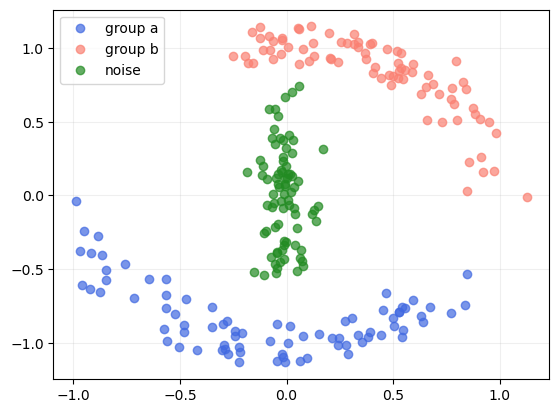

In [7]:
fig, ax = plt.subplots()
ax.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
ax.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
ax.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='noise')
ax.grid(alpha=0.2)
ax.legend()

In [8]:
whole_data = np.vstack((a_group,b_group,gaussian_noise))

In [9]:
kmeans_boundaries = KMeans(n_clusters=3).fit(X=whole_data)

In [10]:
xx, yy = np.meshgrid(np.linspace(-1.2,1.2,200), np.linspace(-1.2,1.2,200))
results_plot = np.empty(200**2)
for i in tqdm(range(200**2)):
    results_plot[i] = kmeans_boundaries.predict(np.c_[xx.ravel(), yy.ravel()][i,:].reshape(1,-1))[0]
Z = results_plot
Z = Z.reshape(xx.shape)

100%|██████████| 40000/40000 [00:08<00:00, 4809.05it/s]


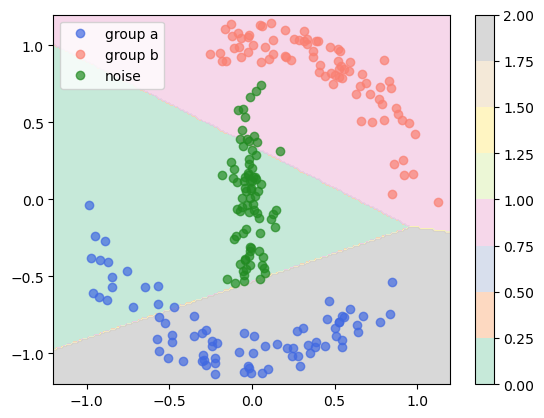

In [11]:
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.Pastel2)
plt.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
plt.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
plt.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='noise')
plt.legend()
plt.colorbar()
plt.show()

We have to find the solutions of the following Wolfe Lagrangian : 

$$W = \sum_{j}K(x_j,x_j)\beta_j - \sum_{i,j}K(x_i,x_j)\beta_i\beta_j$$

In order to use a quadratic solver, we have to rewrite a little bit the above problem. 

Let's denote by $K_{diag}$ the vector containing only the diagonal elements of the Gram matrix K. We denote by $\beta$ the vector which has entries $\{\beta_i\}_{i=1}^n$, moreover, we denote by $\mathbb{1}$ the vector of lentgh $n$ containing only ones.

Hence, we can rewrite the above dual as : 

$$ W = K_{diag}^T \beta + \beta^T K \beta $$

And hence, to get the FOC's to determine $\beta$, we have : 
 $$ \nabla W = K_{diag} + K \beta = 0$$


Nevertheless, the qpsolvers library provides solvers for the quadratic problems of the shape : 

$$ \min_x \frac{1}{2} x^T P x + q^Tx $$

$$ \text{s.t.} \quad Gx \leq h, \quad \quad Ax = b, \quad \quad lb \leq x \leq ub $$

We will hence need to set $K = -2K$ to respect the formulation of the solver.

In [12]:
#to find an adequate q for the width of the kernel
norms_q = np.linalg.norm(whole_data, axis=1)**2
dot_q = whole_data@whole_data.T
squared_euclidian_distances_q = norms_q[:, None] - 2 * dot_q + norms_q[None, :]

In [13]:
q = 1/(np.max(squared_euclidian_distances_q))
gram_x = gram_mat(X=whole_data,q=q)

In [26]:
kdiag = np.ones(n)
P = -2*gram_x
P = spa.csc_matrix(P)
P += P.T
P /= 2
q = kdiag
lb = np.zeros(n)
ub = C*np.ones(n)

beta = solve_qp(P=P,q=q,lb=lb,ub=ub,solver='clarabel')

/opt/conda/lib/python3.12/site-packages/qpsolvers/solvers/clarabel_.py:138: UserWarning: Clarabel.rs terminated with status NumericalError
  warnings.warn(f"Clarabel.rs terminated with status {result.status}")
